In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import gym
import numpy as np
import random


import os, sys
sys.path.insert(0,'..')

from collections import deque 

from dfibert.tracker.nn.rl import Agent, DQN
import dfibert.envs.RLtractEnvironment as RLTe
from dfibert.envs._state import TractographyState

import matplotlib.pyplot as plt
%matplotlib notebook

In [2]:
env = RLTe.RLtractEnvironment(stepWidth=1.0, action_space=20, maxL2dist_to_State=0.2, device = 'cpu', pReferenceStreamlines='data/HCP307200_DTI_min40.vtk')
#env = RLTe.RLtractEnvironment(stepWidth=0.3, action_space=20, device = 'cpu', pReferenceStreamlines='data/HCP307200_DTI_min40.vtk')
n_actions = env.action_space.n

Loading precomputed streamlines (data/HCP307200_DTI_min40.vtk) for ID 100307


In [3]:
max_steps = 30000000
replay_memory_size = 100000
agent_history_length = 1
evaluate_every = 200000
eval_runs = 5#20
network_update_every = 10000
start_learning = 10000
eps_annealing_steps = 400000

max_episode_length = 2000
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

batch_size = 512
learning_rate = 0.000001 

In [ ]:
state = env.reset().getValue()
print(state.shape)
agent = Agent(n_actions=n_actions, inp_size=state.shape, device=device, hidden=10, gamma=0.99, agent_history_length=agent_history_length, memory_size=replay_memory_size, batch_size=batch_size, learning_rate=learning_rate)

(100, 3, 3, 3)


In [6]:
#### Fill replay memory with perfect actions for supervised approach

from tqdm import trange
#state = env.reset().getValue()
#agent = Agent(n_actions=n_actions, inp_size=state.shape, device=device, hidden=10, gamma=0.99, agent_history_length=agent_history_length, memory_size=replay_memory_size, batch_size=512, learning_rate=learning_rate)

overall_runs = 0
overall_reward = []
for overall_runs in trange(30):
    state = env.reset(streamline_index=overall_runs)
    #episode_step_counter = 0
    episode_reward = 0
    terminal = False
    #print("New run")
    #print(env.stepCounter, state.getCoordinate().numpy())
    while not terminal:
        #print(env.stepCounter)
        #if np.random.rand(1) < 0.1: 
        #    action = np.random.randint(0, n_actions)
        #else:
        action = env._get_best_action()
        next_state, reward, terminal, _ = env.step(action)
        
            
        agent.replay_memory.add_experience(action=action,
                                state = state.getValue(),
                                reward=reward,
                                new_state = next_state.getValue(),
                                terminal=terminal)
        
        episode_reward += reward
        
        state = next_state
        
        if terminal == True:
            break
            
            
    overall_runs += 1
    overall_reward.append(episode_reward)
    print(overall_runs, np.mean(overall_reward[-100:]))
print("Replay memory ready")

  3%|▎         | 1/30 [00:07<03:40,  7.61s/it]

Defi reached the terminal state!
1 143.0310988478278


  7%|▋         | 2/30 [00:15<03:36,  7.73s/it]

Defi reached the terminal state!
2 158.88377874630112


 10%|█         | 3/30 [00:24<03:40,  8.18s/it]

Defi reached the terminal state!
3 177.3485298124357


 13%|█▎        | 4/30 [00:36<04:00,  9.24s/it]

Defi reached the terminal state!
4 202.33509179819157


 17%|█▋        | 5/30 [00:44<03:40,  8.80s/it]

Defi reached the terminal state!
5 197.36385478114923


 20%|██        | 6/30 [00:51<03:22,  8.42s/it]

Defi reached the terminal state!
6 192.20006650671598


 23%|██▎       | 7/30 [00:56<02:44,  7.15s/it]

Defi reached the terminal state!
7 176.8544417912811


 27%|██▋       | 8/30 [01:00<02:17,  6.26s/it]

Defi reached the terminal state!
8 165.0404034327924


 30%|███       | 9/30 [01:09<02:28,  7.07s/it]

Defi reached the terminal state!
9 169.62865404483904


 33%|███▎      | 10/30 [01:30<03:44, 11.23s/it]

Defi reached the terminal state!
10 198.63813630466953


 37%|███▋      | 11/30 [01:36<03:07,  9.88s/it]

Defi reached the terminal state!
11 194.26243209833217


 40%|████      | 12/30 [01:40<02:23,  7.95s/it]

Defi reached the terminal state!
12 183.59664528673034


 43%|████▎     | 13/30 [01:43<01:50,  6.53s/it]

Defi reached the terminal state!
13 173.63848845631915


 47%|████▋     | 14/30 [01:48<01:38,  6.16s/it]

Defi reached the terminal state!
14 169.24786793469374


 50%|█████     | 15/30 [02:07<02:30, 10.05s/it]

Defi reached the terminal state!
15 187.62549357274204


 53%|█████▎    | 16/30 [02:18<02:24, 10.33s/it]

Defi reached the terminal state!
16 191.76283930612405


 57%|█████▋    | 17/30 [02:23<01:51,  8.61s/it]

Defi reached the terminal state!
17 186.22058669560369


 60%|██████    | 18/30 [02:30<01:36,  8.06s/it]

Defi reached the terminal state!
18 184.36469690526525


 63%|██████▎   | 19/30 [02:39<01:31,  8.33s/it]

Defi reached the terminal state!
19 185.65322453814596


 67%|██████▋   | 20/30 [02:51<01:35,  9.58s/it]

Defi reached the terminal state!
20 190.15118657864878


 70%|███████   | 21/30 [02:56<01:13,  8.21s/it]

Defi reached the terminal state!
21 186.00315056319965


 73%|███████▎  | 22/30 [03:15<01:32, 11.50s/it]

Defi reached the terminal state!
22 197.99876251434122


 77%|███████▋  | 23/30 [03:28<01:22, 11.76s/it]

Defi reached the terminal state!
23 202.0185916403163


 80%|████████  | 24/30 [03:41<01:12, 12.06s/it]

Defi reached the terminal state!
24 205.98706345956512


 83%|████████▎ | 25/30 [03:55<01:03, 12.76s/it]

Defi reached the terminal state!
25 210.89181421565198


 87%|████████▋ | 26/30 [04:01<00:43, 10.86s/it]

Defi reached the terminal state!
26 208.2704861322131


 90%|█████████ | 27/30 [04:11<00:31, 10.46s/it]

Defi reached the terminal state!
27 208.5920298092779


 93%|█████████▎| 28/30 [04:23<00:21, 10.87s/it]

Defi reached the terminal state!
28 210.4216536423689


 97%|█████████▋| 29/30 [04:28<00:09,  9.31s/it]

Defi reached the terminal state!
29 207.2809612907575


100%|██████████| 30/30 [04:41<00:00,  9.38s/it]

Defi reached the terminal state!
30 209.9179836791539
Replay memory ready


In [7]:
torch.optim.Adam(agent.target_dqn.parameters(), 0.0001)
losses = []
for i in trange(80000):
    states, actions, _, _, _ = agent.replay_memory.get_minibatch()

    states = torch.FloatTensor(states).to(agent.device)
    actions = torch.LongTensor(actions).to(agent.device)
    predicted_q = agent.main_dqn(states)
    loss = torch.nn.functional.cross_entropy(predicted_q, actions)
    #print(loss.item())
    agent.optimizer.zero_grad()
    loss.backward()
    agent.optimizer.step()
    losses.append(loss.item())
    
mean_losses = []
for i in range(len(losses)):
    mean_losses.append(np.mean(losses[i:i+99]))
#print(mean_losses[-20:])

fig, ax = plt.subplots()
ax.plot(range(len(losses[:])), losses[:])
ax.plot(range(len(losses[:])), mean_losses[:])
plt.show()

 15%|█▍        | 11821/80000 [01:32<08:51, 128.37it/s]


KeyboardInterrupt: 

In [40]:
states, actions, _, _, _ = agent.replay_memory.get_minibatch()
states = torch.FloatTensor(states).to(agent.device)
predicted_q = torch.argmax(agent.main_dqn(states), dim=1)

false = 0
for i in range(len(actions)):
    if predicted_q[i] != actions[i]:
        false += 1 
    
print("Accuracy =", 1 - false / len(actions))

Accuracy = 0.611328125


Training cell

In [ ]:
step_counter = 0
eps_rewards = []
episode_lengths = []

losses = []

eps = 1.0

print("Start training...")
while step_counter < max_steps:
    epoch_step = 0
    while (epoch_step < evaluate_every) or (step_counter < start_learning):
        state = env.reset()
        episode_reward_sum = 0
        terminal = False
        episode_step_counter = 0
        positive_run = 0
        points_visited = 0
        
        negative_rewards = 0
        
        
        # reduce epsilon
        if step_counter > start_learning:
            eps = max(eps * 0.999, 0.01)
        
        # play an episode
        while episode_step_counter <= 1000.:
            
            # get an action with epsilon-greedy strategy
            if random.random() < eps:                                 
                action = np.random.randint(env.action_space.n)           # either random action
                #action = env._get_best_action()
            else:                                                        # or action from agent
                agent.main_dqn.eval()
                with torch.no_grad():
                    state_v = torch.from_numpy(state.getValue()).unsqueeze(0).float().to(device)
                    action = torch.argmax(agent.main_dqn(state_v)).item()
                agent.main_dqn.train()
            
            # perform step on environment
            next_state, reward, terminal, _ = env.step(action)

            
            episode_step_counter += 1
            step_counter += 1
            epoch_step += 1
            
            episode_reward_sum += reward
            
            # store experience in replay buffer
            agent.replay_memory.add_experience(action=action, state = state.getValue(), reward=reward, new_state = next_state.getValue(), terminal=terminal)
            
            state = next_state
            
            # optimize agent after certain amount of steps
            if step_counter > start_learning and step_counter % 4 == 0:
                
                # original optimization function
                #agent.optimize()
                
                ### debugging optimization function
                
                states, actions, rewards, new_states, terminal_flags = agent.replay_memory.get_minibatch()
                
                #states = torch.tensor(states)#.view(replay_memory.batch_size, -1) # 1, -1
                #next_states = torch.tensor(new_states)#.view(replay_memory.batch_size, -1)
                #actions = torch.LongTensor(actions)
                #rewards = torch.tensor(rewards)
                #terminal_flags = torch.BoolTensor(terminal_flags)

                states = torch.from_numpy(states).to(device)
                next_states = torch.from_numpy(new_states).to(device)
                actions = torch.from_numpy(actions).unsqueeze(1).long().to(device)
                rewards = torch.from_numpy(rewards).to(device)
                terminal_flags = torch.from_numpy(terminal_flags).to(device)
                
                
                state_action_values = agent.main_dqn(states).gather(1, actions).squeeze(-1)
                next_state_actions = torch.argmax(agent.main_dqn(next_states), dim=1)
                next_state_values = agent.target_dqn(next_states).gather(1, next_state_actions.unsqueeze(-1)).squeeze(-1)
                #
                next_state_values[terminal_flags] = 0.0
                #
                expected_state_action_values = next_state_values.detach() * 0.9995 + rewards
                #
                loss = F.smooth_l1_loss(state_action_values, expected_state_action_values)
                losses.append(loss)
                agent.optimizer.zero_grad()
                loss.backward()
                agent.optimizer.step()
                
            # update target network after certain amount of steps    
            #if step_counter > start_learning and step_counter % network_update_every == 0:
            #    agent.target_dqn.load_state_dict(agent.main_dqn.state_dict())
            
            # if epsiode has ended, step out of the episode while loop
            if terminal:
                break
                
        # keep track of past episode rewards
        eps_rewards.append(episode_reward_sum)
        if len(eps_rewards) % 20 == 0:
            print("{}, done {} episodes, {}, mean loss: {} ,current epsilon {}".format(step_counter, len(eps_rewards), np.mean(eps_rewards[-100:]), np.mean(losses[-100:]) ,eps))#action_scheduler.eps_current))
            
    ## evaluation        
    eval_rewards = []
    episode_final = 0
    agent.main_dqn.eval()
    for _ in range(eval_runs):
        eval_steps = 0
        state = env.reset()
        
        eval_episode_reward = 0
        negative_rewards = 0
        
        # play an episode
        while eval_steps < 1000:
            # get the action from the agent
            with torch.no_grad():
                    state_v = torch.from_numpy(state.getValue()).unsqueeze(0).float().to(device)
                    action = torch.argmax(agent.main_dqn(state_v)).item()
                  
            # perform a step on the environment
            next_state, reward, terminal, _ = env.step(action)
            
            eval_steps += 1
            
            eval_episode_reward += reward
            state = next_state
            
            # step out of the episode while loop if 
            if terminal:
                terminal = False
                if reward == 1.:
                    episode_final += 1
                break

        eval_rewards.append(eval_episode_reward)

    print("Evaluation score:", np.mean(eval_rewards))
    print("{} of {} episodes ended close to / at the final state.".format(episode_final, eval_runs))

Evaluating trained agent

In [24]:
eval_rewards = []
all_distances = []
all_states = []
#agent.main_dqn.eval()
for _ in range(1):
    eval_steps = 0
    state = env.reset(streamline_index=2)    
    #state = env.reset()
    #print(state.getCoordinate())
    all_states.append(state.getCoordinate())
    #transition = init_transition()
    #all_states.append(torch.tensor(list(transition)[:3]))
    eval_episode_reward = 0
    episode_final = 0
    #print(env.referenceStreamline_ijk[:6])
    
    while eval_steps < max_episode_length:
        #action = torch.argmax(main_dqn(torch.FloatTensor(state.getValue()).unsqueeze(0).to(device)))
        action = env._get_best_action()
        #with torch.no_grad():
        #    state_v = torch.from_numpy(state.getValue()).unsqueeze(0).float().to(device)
        #    action = torch.argmax(agent.target_dqn(state_v)).item()
        next_state, reward, terminal, _ = env.step(action)
        
        eval_episode_reward += reward
        print(eval_steps, action, next_state.getCoordinate().numpy(), env.referenceStreamline_ijk[np.min([env.stepCounter,len(env.referenceStreamline_ijk)-1])].numpy(), reward)       
        eval_steps += 1
        if eval_steps == 1000:
            terminal = True
        all_distances.append(reward)
        all_states.append(next_state.getCoordinate())
        
        state = next_state
        if terminal:
            terminal = False
            break

    eval_rewards.append(eval_episode_reward)

print("Evaluation score:", np.min(eval_rewards))

0 12 [ 63.01181039 129.07140205  42.02730397] [ 62.921745 128.58087   42.524906] tensor(0.2955, dtype=torch.float64)
1 12 [ 62.98775117 129.02729506  42.11376626] [ 62.807625 128.04623   43.10897 ] tensor(0.3895, dtype=torch.float64)
2 12 [ 62.96369196 128.98318807  42.20022855] [ 62.586143 127.418526  43.552746] tensor(0.4813, dtype=torch.float64)
3 16 [ 62.99299336 128.906947    42.25792368] [ 62.47202  126.88388   44.136814] tensor(0.5726, dtype=torch.float64)
4 2 [ 62.94526193 128.84962177  42.32452345] [ 62.4582  126.38859  44.7649 ] tensor(0.6639, dtype=torch.float64)
5 12 [ 62.92120271 128.80551479  42.41098574] [ 62.53108 125.77119  45.26839] tensor(-0.0376, dtype=torch.float64)
6 12 [ 62.8971435  128.7614078   42.49744803] [ 62.60396  125.153786  45.771885] tensor(0.0548, dtype=torch.float64)
7 16 [ 62.92644489 128.68516673  42.55514316] [ 62.57769  124.50053   46.232925] tensor(0.1461, dtype=torch.float64)
8 2 [ 62.87871346 128.6278415   42.62174292] [ 62.550262 123.78921   4

74 3 [ 62.62957647 124.04061859  46.49536076] [ 79.61447 130.48387  45.85026] tensor(-0.0788, dtype=torch.float64)
75 2 [ 62.58184504 123.98329337  46.56196052] [ 79.45291  131.26651   45.813255] tensor(0.0102, dtype=torch.float64)
76 3 [ 62.60676984 123.89137782  46.59246113] [ 79.34004 132.05122  45.92046] tensor(0.0997, dtype=torch.float64)
77 2 [ 62.55903841 123.83405259  46.6590609 ] [ 79.20889 132.80864  46.14206] tensor(0.1884, dtype=torch.float64)
78 3 [ 62.58396321 123.74213705  46.6895615 ] [ 79.16058 133.55014  46.43847] tensor(0.2777, dtype=torch.float64)
79 2 [ 62.53623178 123.68481182  46.75616127] [ 79.112274 134.29163   46.734875] tensor(0.3659, dtype=torch.float64)
80 3 [ 62.56115658 123.59289628  46.78666187] [ 79.14082  135.00061   47.104374] tensor(0.4548, dtype=torch.float64)
81 2 [ 62.51342515 123.53557105  46.85326164] [ 79.169365 135.7096    47.473873] tensor(0.5418, dtype=torch.float64)
82 3 [ 62.53834995 123.44365551  46.88376224] [ 79.121056 136.45108   47.77

149 3 [ 62.98365466 118.20575477  50.09378359] [ 76.80438 140.32927  47.28899] tensor(0.4715, dtype=torch.float64)
150 3 [ 63.00857946 118.11383922  50.12428419] [ 76.80438 140.32927  47.28899] tensor(0.5489, dtype=torch.float64)
151 17 [ 63.04212312 118.01995389  50.13205382] [ 76.80438 140.32927  47.28899] tensor(-0.0950, dtype=torch.float64)
152 17 [ 63.07566677 117.92606855  50.13982344] [ 76.80438 140.32927  47.28899] tensor(-0.0041, dtype=torch.float64)
153 3 [ 63.10059157 117.83415301  50.17032405] [ 76.80438 140.32927  47.28899] tensor(0.0851, dtype=torch.float64)
154 17 [ 63.13413523 117.74026767  50.17809367] [ 76.80438 140.32927  47.28899] tensor(0.1719, dtype=torch.float64)
155 3 [ 63.15906003 117.64835213  50.20859427] [ 76.80438 140.32927  47.28899] tensor(0.2558, dtype=torch.float64)
156 17 [ 63.19260369 117.55446679  50.2163639 ] [ 76.80438 140.32927  47.28899] tensor(0.3353, dtype=torch.float64)
157 18 [ 63.11271233 117.49818904  50.19514631] [ 76.80438 140.32927  47.2

224 8 [ 66.20090463 113.19619516  50.45464725] [ 76.80438 140.32927  47.28899] tensor(0.4317, dtype=torch.float64)
225 17 [ 66.23444828 113.10230982  50.46241687] [ 76.80438 140.32927  47.28899] tensor(0.5066, dtype=torch.float64)
226 8 [ 66.32906542 113.11079479  50.49365153] [ 76.80438 140.32927  47.28899] tensor(0.5750, dtype=torch.float64)
227 17 [ 66.36260907 113.01690945  50.50142115] [ 76.80438 140.32927  47.28899] tensor(-0.0882, dtype=torch.float64)
228 17 [ 66.39615273 112.92302412  50.50919078] [ 76.80438 140.32927  47.28899] tensor(-0.0107, dtype=torch.float64)
229 8 [ 66.49076986 112.93150909  50.54042543] [ 76.80438 140.32927  47.28899] tensor(0.0697, dtype=torch.float64)
230 17 [ 66.52431352 112.83762375  50.54819506] [ 76.80438 140.32927  47.28899] tensor(0.1467, dtype=torch.float64)
231 8 [ 66.61893065 112.84610872  50.57942971] [ 76.80438 140.32927  47.28899] tensor(0.2272, dtype=torch.float64)
232 17 [ 66.6524743  112.75222338  50.58719934] [ 76.80438 140.32927  47.2

300 14 [ 70.30810717 110.22969084  54.28963704] [ 76.80438 140.32927  47.28899] tensor(-0.0345, dtype=torch.float64)
301 14 [ 70.35940862 110.21262392  54.37376125] [ 76.80438 140.32927  47.28899] tensor(0.0637, dtype=torch.float64)
302 14 [ 70.41071007 110.19555699  54.45788545] [ 76.80438 140.32927  47.28899] tensor(0.1615, dtype=torch.float64)
303 14 [ 70.46201152 110.17849007  54.54200965] [ 76.80438 140.32927  47.28899] tensor(0.2587, dtype=torch.float64)
304 14 [ 70.51331298 110.16142315  54.62613385] [ 76.80438 140.32927  47.28899] tensor(0.3551, dtype=torch.float64)
305 14 [ 70.56461443 110.14435623  54.71025805] [ 76.80438 140.32927  47.28899] tensor(0.4501, dtype=torch.float64)
306 14 [ 70.61591588 110.12728931  54.79438225] [ 76.80438 140.32927  47.28899] tensor(0.5431, dtype=torch.float64)
307 14 [ 70.66721733 110.11022238  54.87850645] [ 76.80438 140.32927  47.28899] tensor(0.6323, dtype=torch.float64)
308 15 [ 70.72043465 110.0985486   54.96236133] [ 76.80438 140.32927  4

374 2 [ 75.31017837 112.20834842  56.96886388] [ 76.80438 140.32927  47.28899] tensor(-0.0666, dtype=torch.float64)
375 2 [ 75.3579098  112.26567365  56.90226412] [ 76.80438 140.32927  47.28899] tensor(0.0163, dtype=torch.float64)
376 2 [ 75.40564123 112.32299888  56.83566435] [ 76.80438 140.32927  47.28899] tensor(0.0958, dtype=torch.float64)
377 2 [ 75.45337266 112.3803241   56.76906458] [ 76.80438 140.32927  47.28899] tensor(0.1708, dtype=torch.float64)
378 8 [ 75.5479898  112.38880907  56.80029924] [ 76.80438 140.32927  47.28899] tensor(0.2476, dtype=torch.float64)
379 2 [ 75.59572123 112.44613429  56.73369947] [ 76.80438 140.32927  47.28899] tensor(0.3204, dtype=torch.float64)
380 8 [ 75.69033836 112.45461926  56.76493413] [ 76.80438 140.32927  47.28899] tensor(0.3948, dtype=torch.float64)
381 5 [ 75.73562556 112.44179163  56.67670419] [ 76.80438 140.32927  47.28899] tensor(0.4712, dtype=torch.float64)
382 8 [ 75.83024269 112.4502766   56.70793885] [ 76.80438 140.32927  47.28899] 

448 5 [ 79.64469503 114.37869196  53.43378792] [ 76.80438 140.32927  47.28899] tensor(0.3090, dtype=torch.float64)
449 8 [ 79.73931216 114.38717693  53.46502257] [ 76.80438 140.32927  47.28899] tensor(0.3862, dtype=torch.float64)
450 5 [ 79.78459936 114.3743493   53.37679264] [ 76.80438 140.32927  47.28899] tensor(0.4583, dtype=torch.float64)
451 8 [ 79.87921649 114.38283427  53.4080273 ] [ 76.80438 140.32927  47.28899] tensor(0.5358, dtype=torch.float64)
452 2 [ 79.92694793 114.44015949  53.34142753] [ 76.80438 140.32927  47.28899] tensor(0.6090, dtype=torch.float64)
453 2 [ 79.97467936 114.49748472  53.27482776] [ 76.80438 140.32927  47.28899] tensor(-0.0383, dtype=torch.float64)
454 2 [ 80.02241079 114.55480995  53.20822799] [ 76.80438 140.32927  47.28899] tensor(0.0527, dtype=torch.float64)
455 2 [ 80.07014222 114.61213517  53.14162823] [ 76.80438 140.32927  47.28899] tensor(0.1418, dtype=torch.float64)
456 2 [ 80.11787365 114.6694604   53.07502846] [ 76.80438 140.32927  47.28899] 

523 16 [ 81.87141583 118.81620542  49.28927079] [ 76.80438 140.32927  47.28899] tensor(0.2057, dtype=torch.float64)
524 2 [ 81.91914726 118.87353064  49.22267102] [ 76.80438 140.32927  47.28899] tensor(0.2970, dtype=torch.float64)
525 16 [ 81.88984587 118.94977171  49.16497589] [ 76.80438 140.32927  47.28899] tensor(0.3865, dtype=torch.float64)
526 2 [ 81.9375773  119.00709694  49.09837613] [ 76.80438 140.32927  47.28899] tensor(0.4773, dtype=torch.float64)
527 3 [ 81.9126525  119.09901248  49.06787552] [ 76.80438 140.32927  47.28899] tensor(0.5655, dtype=torch.float64)
528 2 [ 81.96038393 119.15633771  49.00127575] [ 76.80438 140.32927  47.28899] tensor(0.6566, dtype=torch.float64)
529 16 [ 81.93108254 119.23257878  48.94358063] [ 76.80438 140.32927  47.28899] tensor(-0.0377, dtype=torch.float64)
530 16 [ 81.90178114 119.30881985  48.8858855 ] [ 76.80438 140.32927  47.28899] tensor(0.0573, dtype=torch.float64)
531 16 [ 81.87247975 119.38506092  48.82819037] [ 76.80438 140.32927  47.28

595 18 [ 80.94889972 124.67105995  46.3252099 ] [ 76.80438 140.32927  47.28899] tensor(0.5479, dtype=torch.float64)
596 3 [ 80.92397492 124.7629755   46.2947093 ] [ 76.80438 140.32927  47.28899] tensor(0.6307, dtype=torch.float64)
597 3 [ 80.89905012 124.85489105  46.26420869] [ 76.80438 140.32927  47.28899] tensor(-0.0534, dtype=torch.float64)
598 17 [ 80.86550646 124.94877638  46.25643907] [ 76.80438 140.32927  47.28899] tensor(0.0374, dtype=torch.float64)
599 3 [ 80.84058166 125.04069193  46.22593847] [ 76.80438 140.32927  47.28899] tensor(0.1264, dtype=torch.float64)
600 17 [ 80.80703801 125.13457726  46.21816884] [ 76.80438 140.32927  47.28899] tensor(0.2128, dtype=torch.float64)
601 3 [ 80.78211321 125.22649281  46.18766824] [ 76.80438 140.32927  47.28899] tensor(0.2960, dtype=torch.float64)
602 17 [ 80.74856955 125.32037814  46.17989861] [ 76.80438 140.32927  47.28899] tensor(0.3743, dtype=torch.float64)
603 18 [ 80.8284609  125.37665589  46.2011162 ] [ 76.80438 140.32927  47.28

667 0 [ 79.25381529 131.19596086  45.86881832] [ 76.80438 140.32927  47.28899] tensor(0.1389, dtype=torch.float64)
668 17 [ 79.22027164 131.28984619  45.8610487 ] [ 76.80438 140.32927  47.28899] tensor(0.2270, dtype=torch.float64)
669 0 [ 79.19661948 131.37909797  45.89945048] [ 76.80438 140.32927  47.28899] tensor(0.3124, dtype=torch.float64)
670 17 [ 79.16307582 131.4729833   45.89168086] [ 76.80438 140.32927  47.28899] tensor(0.3946, dtype=torch.float64)
671 0 [ 79.13942366 131.56223507  45.93008264] [ 76.80438 140.32927  47.28899] tensor(0.4714, dtype=torch.float64)
672 18 [ 79.21931502 131.61851282  45.95130023] [ 76.80438 140.32927  47.28899] tensor(0.5497, dtype=torch.float64)
673 3 [ 79.19439022 131.71042837  45.92079962] [ 76.80438 140.32927  47.28899] tensor(0.6294, dtype=torch.float64)
674 0 [ 79.17073806 131.79968014  45.95920141] [ 76.80438 140.32927  47.28899] tensor(-0.0261, dtype=torch.float64)
675 0 [ 79.1470859  131.88893191  45.99760319] [ 76.80438 140.32927  47.2889

739 17 [ 78.73148776 137.25952907  48.01270311] [ 76.80438 140.32927  47.28899] tensor(0.3331, dtype=torch.float64)
740 0 [ 78.7078356  137.34878085  48.05110489] [ 76.80438 140.32927  47.28899] tensor(0.4240, dtype=torch.float64)
741 17 [ 78.67429195 137.44266618  48.04333526] [ 76.80438 140.32927  47.28899] tensor(0.5132, dtype=torch.float64)
742 0 [ 78.65063979 137.53191795  48.08173705] [ 76.80438 140.32927  47.28899] tensor(0.5978, dtype=torch.float64)
743 3 [ 78.62571499 137.6238335   48.05123644] [ 76.80438 140.32927  47.28899] tensor(0.0038, dtype=torch.float64)
744 3 [ 78.60079019 137.71574904  48.02073584] [ 76.80438 140.32927  47.28899] tensor(0.1029, dtype=torch.float64)
745 17 [ 78.56724653 137.80963438  48.01296621] [ 76.80438 140.32927  47.28899] tensor(0.2021, dtype=torch.float64)
746 3 [ 78.54232173 137.90154992  47.98246561] [ 76.80438 140.32927  47.28899] tensor(0.3011, dtype=torch.float64)
747 17 [ 78.50877808 137.99543526  47.97469599] [ 76.80438 140.32927  47.2889

<IPython.core.display.Javascript object>


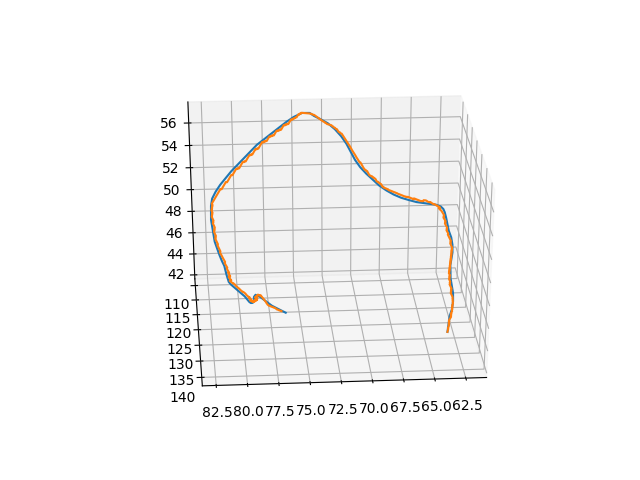

In [25]:
### vizualise streamline
states = torch.stack(all_states)

fig = plt.figure()
ax = plt.axes(projection='3d')
ax.plot3D(env.referenceStreamline_ijk.T[0][:], env.referenceStreamline_ijk.T[1][:], env.referenceStreamline_ijk.T[2][:])
ax.plot3D(states.T[0][:], states.T[1][:], states.T[2][:])

In [3]:
def _get_best_action(env):
    distances = []
    # current_index = np.min([self.closestStreamlinePoint(self.state) + 1, len(self.referenceStreamline_ijk)-1])

    for i in range(env.action_space.n):
        action_vector = env.directions[i]
        action_vector = env._correct_direction(action_vector)
        positionNextState = env.state.getCoordinate() + env.stepWidth * action_vector
        l2_distance = torch.cdist(torch.FloatTensor([env.line.coords[:]]), positionNextState.unsqueeze(dim=0).float(), p=2,).squeeze(0)
        distances.append(torch.min(l2_distance))

    return np.argmin(distances)

In [5]:
next_state = env.reset(50)
action = _get_best_action(env)
print(action)

12


In [10]:
next_state = env.reset(50)
for i in range (5):
    cur_state = next_state
    action = _get_best_action(env)
    next_state, reward, terminal, _ = env.step(action)
    print("[%s] => [%s] | c = %.2f | d = %.2f" % (str(cur_state.getCoordinate().cpu().detach().numpy()), str(next_state.getCoordinate().cpu().detach().numpy()), reward, env.l2_distance))

[[ 0.99902296]
 [ 0.22097087]
 [ 0.6155536 ]
 [ 1.4045128 ]
 [ 2.1870534 ]
 [ 2.9794216 ]
 [ 3.7578044 ]
 [ 4.474319  ]
 [ 5.1671286 ]
 [ 5.8348026 ]
 [ 6.4732018 ]
 [ 7.1441627 ]
 [ 7.839329  ]
 [ 8.521801  ]
 [ 9.183035  ]
 [ 9.867185  ]
 [10.557877  ]
 [11.263013  ]
 [11.980045  ]
 [12.706959  ]
 [13.442296  ]
 [14.18454   ]
 [14.932727  ]
 [15.686006  ]
 [16.443855  ]
 [17.205389  ]
 [17.970299  ]
 [18.739788  ]
 [19.511765  ]
 [20.285896  ]
 [21.049513  ]
 [21.815634  ]
 [22.584152  ]
 [23.354834  ]
 [24.108074  ]
 [24.864222  ]
 [25.582033  ]
 [26.304594  ]
 [27.031448  ]
 [27.76242   ]
 [28.497036  ]
 [29.235088  ]
 [29.976341  ]
 [30.72053   ]
 [31.467508  ]
 [32.198784  ]
 [32.82516   ]
 [33.329308  ]
 [33.793373  ]
 [34.26981   ]
 [34.66959   ]
 [35.13481   ]
 [35.563847  ]
 [36.005573  ]
 [36.48991   ]
 [36.927532  ]
 [37.38989   ]
 [37.863487  ]
 [38.4114    ]
 [38.89273   ]
 [39.458652  ]
 [39.959232  ]
 [40.469463  ]
 [41.039604  ]
 [41.617256  ]
 [42.202175  ]
 [42.59628

In [9]:
env.max_dist_to_referenceStreamline = 0.4